In [ ]:
%%capture
%pip install qiskit==1.4.2 pylatexenc
%pip install qiskit_machine_learning

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import itertools as it
import matplotlib.pyplot as plt
import os
import random
from PIL import Image, ImageDraw
import pandas as pd

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import RYGate
from qiskit.primitives import StatevectorSampler
from qiskit.circuit.parameter import Parameter
from qiskit.circuit.library import MCMT

#**Possibility 1**

Works here, but when used with the QNN outputs error: `Cannot synthesize MCRY with unbound parameter: 6.28318530717959*phi(0, 0).`

In [ ]:
#Define paths to the dataset
DATASET_DIR = "/content/drive/MyDrive/Universidade/Mestrado/Dissertação/Códigos/Synthetic Polyp Dataset Creation - Improved/datasetImproved_50_4by4"
ELLIPSE_DIR = os.path.join(DATASET_DIR, "with_ellipse")
NO_ELLIPSE_DIR = os.path.join(DATASET_DIR, "without_ellipse")
LABELS_FILE = os.path.join(DATASET_DIR, "labels.csv")

#Load the labels file to get image paths
labels_df = pd.read_csv(LABELS_FILE)

In [ ]:
#Function to load and preprocess an image
def load_image(image_path):
  img = Image.open(image_path).convert('L')
  return np.array(img) / 255 * np.pi

In [ ]:
#Select one image with ellipse and one without from the dataset
with_ellipse_sample = labels_df[labels_df['label'] == True].iloc[0]['filename']
without_ellipse_sample = labels_df[labels_df['label'] == False].iloc[0]['filename']

#Load the selected images
image_with_ellipse = load_image(with_ellipse_sample)
image_without_ellipse = load_image(without_ellipse_sample)

In [ ]:
#Function to get control positions for FRQI
def control_positions(row:int, col:int, img_size):
  #Calculate the number of bits needed for row and column
  num_bits = int(np.log2(img_size))
  row_binary = format(row, f'0{num_bits}b')
  col_binary = format(col, f'0{num_bits}b')
  qubit_string = row_binary + col_binary

  return[pos for pos, x in enumerate(reversed(qubit_string)) if x == '0']

In [ ]:
#Function to create a parameterized FRQI circuit
def create_frqi_circuit(img_size):
  """Create a parameterized FRQI circuit for images of size img_size*img_size"""
  #Calculate dimensions
  num_pos_qubits = 2 * int(np.log2(img_size))  #2 sets of qubits: one for rows, one for columns
  num_pixels = img_size * img_size

  #Create quantum registers and ciruit
  qcolor = QuantumRegister(1, 'c')
  qpos = QuantumRegister(num_pos_qubits, 'p')
  creg = ClassicalRegister(num_pos_qubits + 1)  # Add classical register
  qc = QuantumCircuit(qpos, qcolor, creg)
  qc.h(qpos)

  #Create parameters for each pixel
  phi_params = dict()
  #For each pixel, apply a parameterized rotation
  pixel_index = 0
  for i in range(img_size):
    for j in range(img_size):
      control_indices = control_positions(i, j, img_size)
      phi_params[i, j] = Parameter(f"phi{i,j}")
      rotation_gate = MCMT(RYGate(2*np.pi*phi_params[(i, j)]), num_pos_qubits, 1)


      # qc.barrier()
      if control_indices:
        qc.x(control_indices)
      #qc.cry(phi_params[pixel_index], qpos[-1], qcolor[0])  #Apply parameterized rotation RY on the color qubit, controled by the position qubits
      qc.append(rotation_gate, list(range(num_pos_qubits + 1)))
      if control_indices:
        qc.x(control_indices)

      pixel_index += 1

  qc.measure_all()  # Add measurement operations

  return qc, phi_params

In [ ]:
# New sampling function using the parameterized circuit
def run_frqi_v2(image, shots=10000):
  img_size = image.shape[0]
  qc, phi_params = create_frqi_circuit(img_size)

  # Create parameter binding dictionary
  param_binds = {phi_params[i,j]: image[i,j]/(2*np.pi)
                  for i,j in np.ndindex(image.shape)}

  # Use assign_parameters instead of bind_parameters
  bound_circuit = qc.copy()
  for param, value in param_binds.items():
      bound_circuit = bound_circuit.assign_parameters(
          {param: value},
          inplace=False
      )

  # Run simulation
  sampler = StatevectorSampler()
  job = sampler.run([bound_circuit], shots=shots)
  result = job.result()[0]

  return bound_circuit, result

Running FRQI on the image with ellipse...


<ipython-input-62-a753211ef99d>:23: DeprecationWarning: The class ``qiskit.circuit.library.generalized_gates.mcmt.MCMT`` is deprecated as of qiskit 1.4. It will be removed no earlier than 3 months after the release date. Use MCMTGate instead.
  rotation_gate = MCMT(RYGate(2*np.pi*phi_params[(i, j)]), num_pos_qubits, 1)


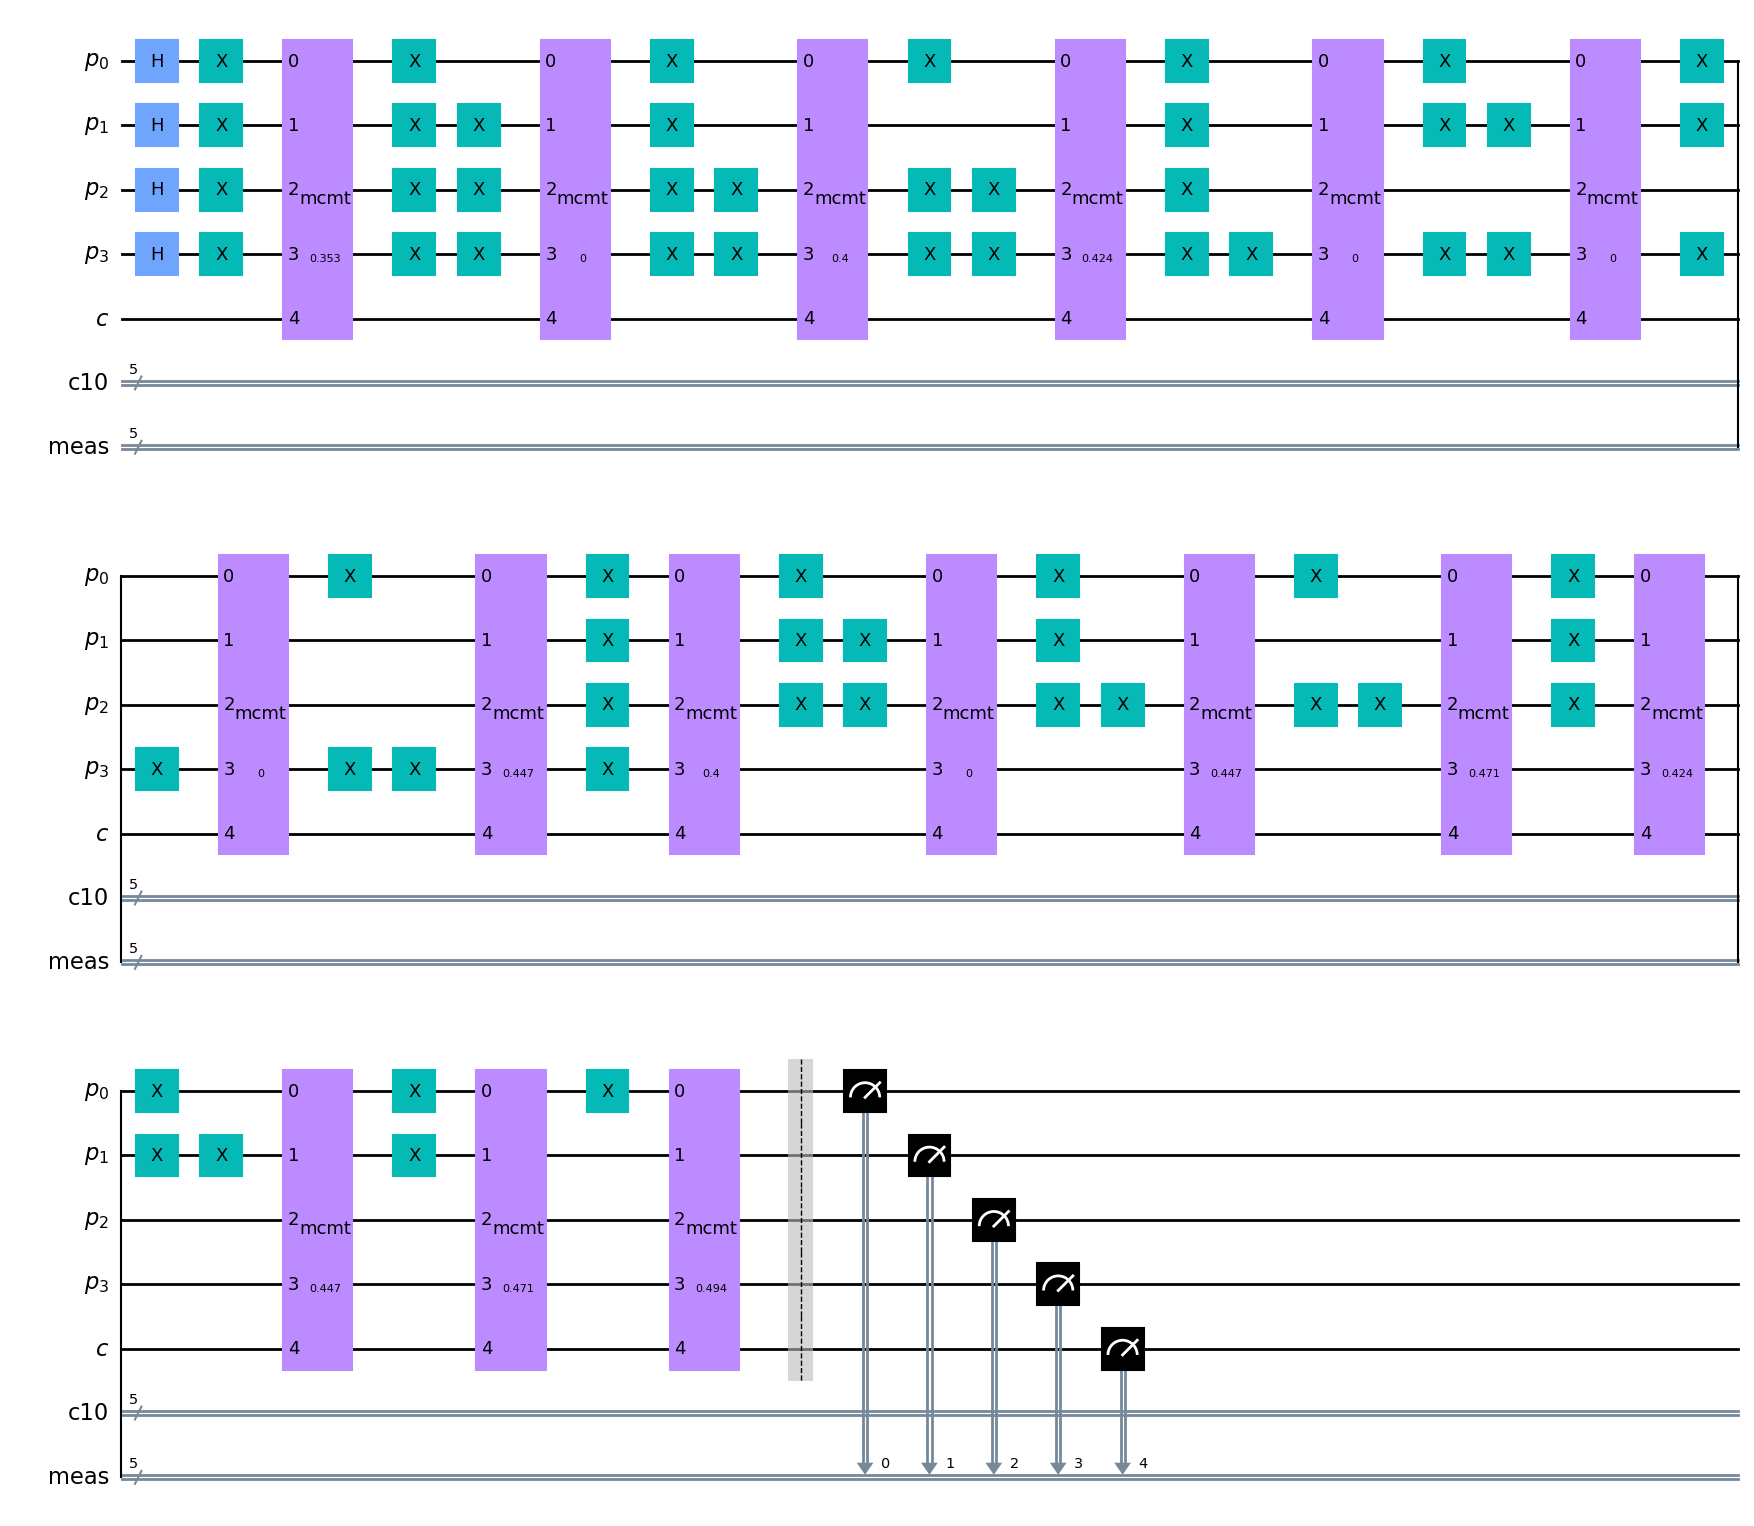

In [ ]:
#Run FRQI for both images
print("Running FRQI on the image with ellipse...")
qc_with_ellipse, result_with_ellipse = run_frqi_v2(image_with_ellipse)
qc_with_ellipse.draw("mpl", style="clifford")

Running FRQI on the image without ellipse...


<ipython-input-62-a753211ef99d>:23: DeprecationWarning: The class ``qiskit.circuit.library.generalized_gates.mcmt.MCMT`` is deprecated as of qiskit 1.4. It will be removed no earlier than 3 months after the release date. Use MCMTGate instead.
  rotation_gate = MCMT(RYGate(2*np.pi*phi_params[(i, j)]), num_pos_qubits, 1)


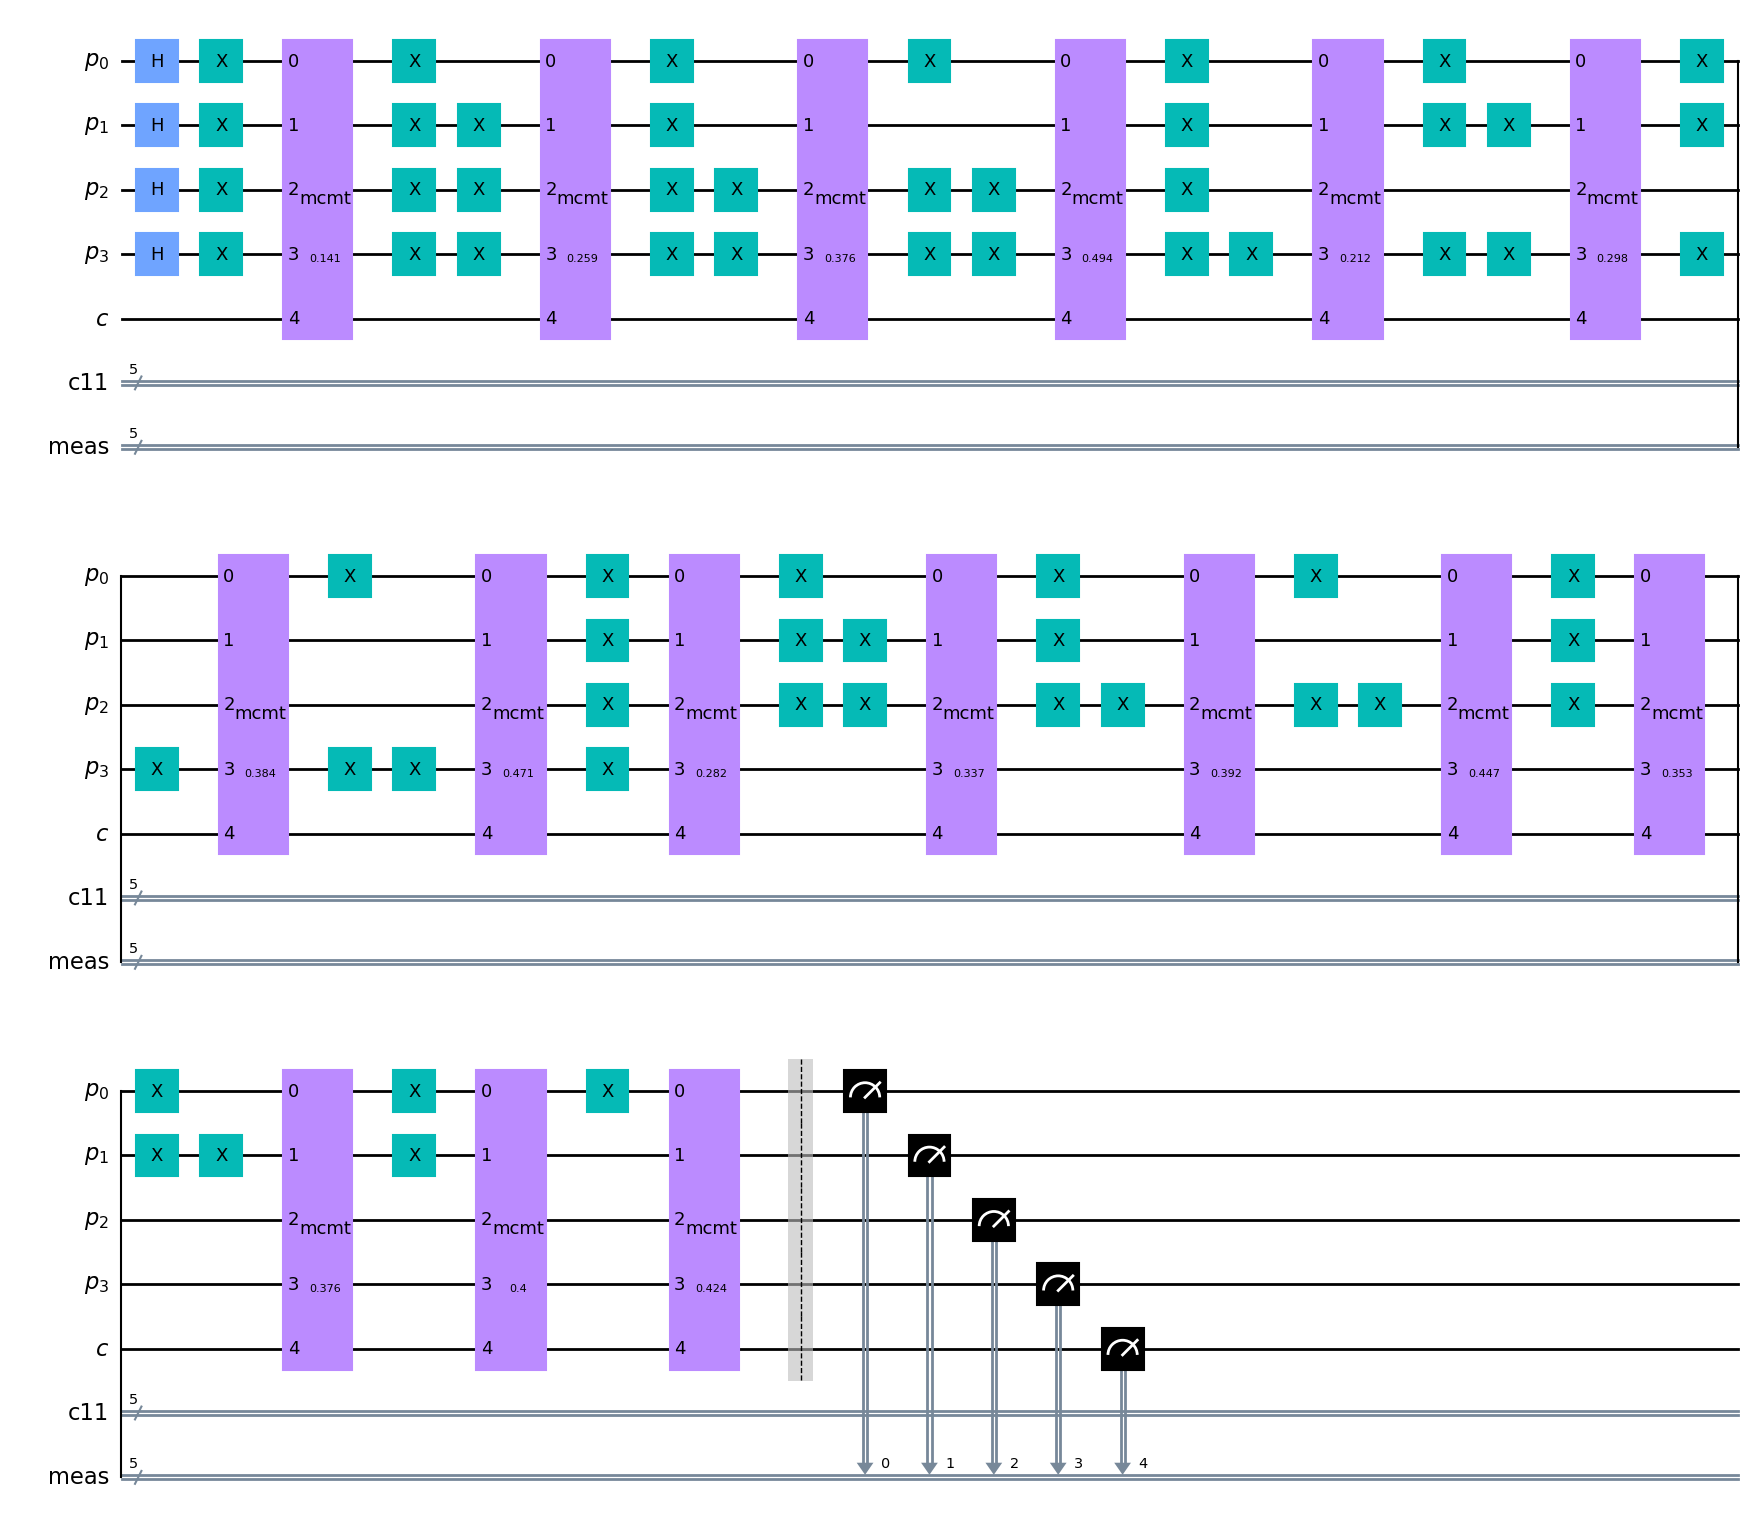

In [ ]:
print("Running FRQI on the image without ellipse...")
qc_without_ellipse, result_without_ellipse = run_frqi_v2(image_without_ellipse)
qc_without_ellipse.draw("mpl", style="clifford")

In [ ]:
#Function to reconstruct image from FRQI results
def reconstruct_image(result, img_size, shots):
  reconstruction = np.zeros((img_size, img_size))
  num_bits = int(np.log2(img_size))

  for i, j in it.product(range(img_size), repeat=2):
    ibin = format(i, f'0{num_bits}b')
    jbin = format(j, f'0{num_bits}b')
    qubit_string_0 = '0' + ibin + jbin  #'1' is for the color qubit
    qubit_string_1 = '1' + ibin + jbin  #'1' is for the color qubit

    N0 = result.data.meas.get_counts().get(qubit_string_0, 0)
    N1 = result.data.meas.get_counts().get(qubit_string_1, 0)
    reconstruction[i, j] = N1 / (N0 + N1)

  return reconstruction

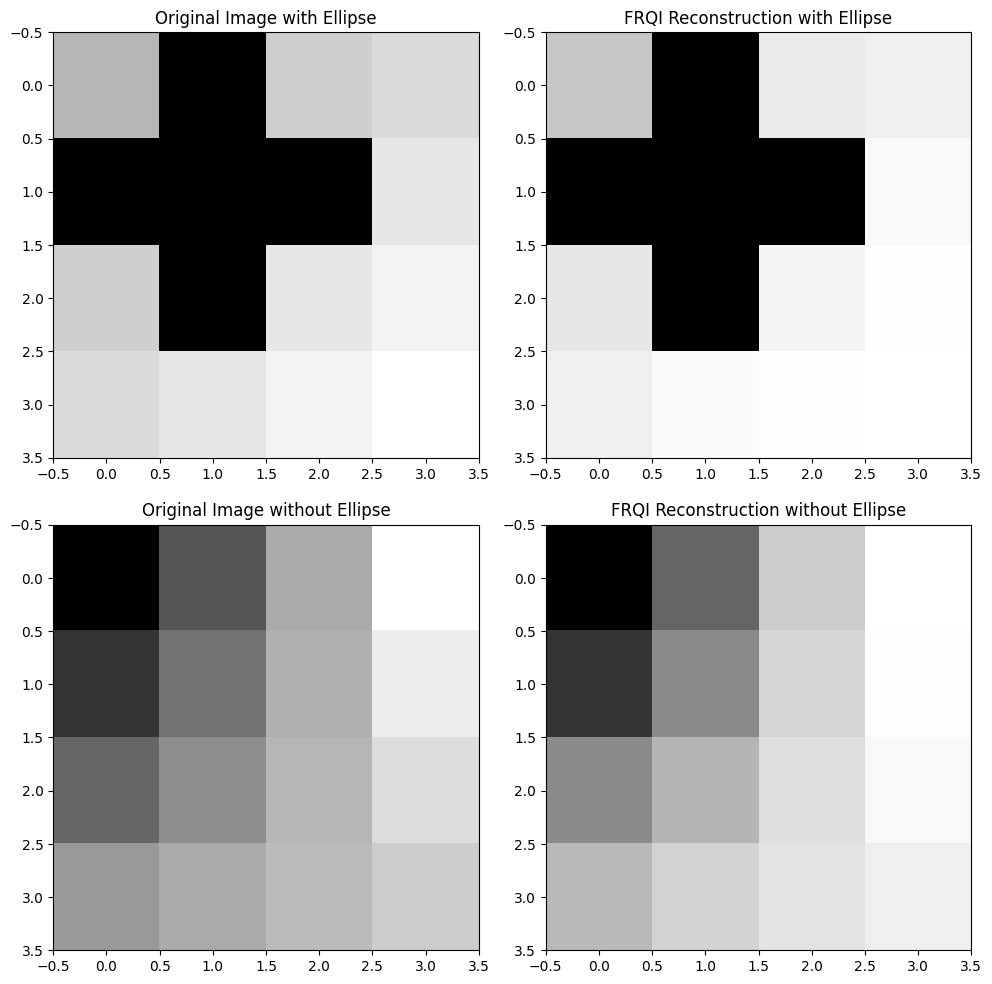

In [ ]:
#Reconstruct the images
img_size = image_with_ellipse.shape[0]
reconstruction_with_ellipse = reconstruct_image(result_with_ellipse, img_size, 10000)
reconstruction_without_ellipse = reconstruct_image(result_without_ellipse, img_size, 10000)

#Visualize the results
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0, 0].imshow(image_with_ellipse, cmap='gray')
axs[0, 0].set_title('Original Image with Ellipse')

axs[0, 1].imshow(reconstruction_with_ellipse, cmap='gray')
axs[0, 1].set_title('FRQI Reconstruction with Ellipse')

axs[1, 0].imshow(image_without_ellipse, cmap='gray')
axs[1, 0].set_title('Original Image without Ellipse')

axs[1, 1].imshow(reconstruction_without_ellipse, cmap='gray')
axs[1, 1].set_title('FRQI Reconstruction without Ellipse')

plt.tight_layout()
plt.show()

#**Possibility 2**

In [ ]:
#Define paths to the dataset
DATASET_DIR = "/content/drive/MyDrive/Universidade/Mestrado/Dissertação/Códigos/Synthetic Polyp Dataset Creation - Improved/datasetImproved_50_4by4"
ELLIPSE_DIR = os.path.join(DATASET_DIR, "with_ellipse")
NO_ELLIPSE_DIR = os.path.join(DATASET_DIR, "without_ellipse")
LABELS_FILE = os.path.join(DATASET_DIR, "labels.csv")

#Load the labels file to get image paths
labels_df = pd.read_csv(LABELS_FILE)

In [ ]:
#Function to load and preprocess an image
def load_image(image_path):
  img = Image.open(image_path).convert('L')
  return np.array(img) / 255 * np.pi

In [ ]:
#Select one image with ellipse and one without from the dataset
with_ellipse_sample = labels_df[labels_df['label'] == True].iloc[0]['filename']
without_ellipse_sample = labels_df[labels_df['label'] == False].iloc[0]['filename']

#Load the selected images
image_with_ellipse = load_image(with_ellipse_sample)
image_without_ellipse = load_image(without_ellipse_sample)

In [ ]:
#Function to get control positions for FRQI
def control_positions(row:int, col:int, img_size):
  #Calculate the number of bits needed for row and column
  num_bits = int(np.log2(img_size))
  row_binary = format(row, f'0{num_bits}b')
  col_binary = format(col, f'0{num_bits}b')
  qubit_string = row_binary + col_binary

  return[pos for pos, x in enumerate(reversed(qubit_string)) if x == '0']

In [ ]:
def multi_controlled_ry_gray_code(qc, controls, target, theta):
    """
    Decompose multi-controlled Ry using Gray code method
    """
    n_controls = len(controls)
    n_rotations = 2**n_controls

    # Apply Ry rotations with Gray code CNOT sequence
    for i in range(n_rotations):
        # Calculate rotation angle for this step
        angle = theta / n_rotations

        # Apply Ry rotation
        qc.ry(angle, target)

        # Apply CNOT based on Gray code if not last iteration
        if i < n_rotations - 1:
            # Find which bit changes in Gray code sequence
            gray_current = i ^ (i >> 1)
            gray_next = (i + 1) ^ ((i + 1) >> 1)
            changed_bit = gray_current ^ gray_next

            # Find position of changed bit
            control_qubit = 0
            while (changed_bit >> control_qubit) & 1 == 0:
                control_qubit += 1

            # Apply CNOT
            qc.cx(controls[control_qubit], target)


In [ ]:
def multi_controlled_ry_recursive(qc, controls, target, theta):
    """
    Recursively decompose multi-controlled Ry
    """
    n_controls = len(controls)

    if n_controls == 0:
        qc.ry(theta, target)
    elif n_controls == 1:
        qc.cry(theta, controls[0], target)
    elif n_controls == 2:
        # Use the 2-controlled pattern
        qc.cry(theta/2, controls[1], target)
        qc.cx(controls[0], controls[1])
        qc.cry(-theta/2, controls[1], target)
        qc.cx(controls[0], controls[1])
        qc.cry(theta/2, controls[0], target)
    else:
        # Split controls in half and apply recursively
        mid = n_controls // 2
        controls1 = controls[:mid]
        controls2 = controls[mid:]

        # This requires an ancilla qubit approach or further decomposition
        # For simplicity, use the iterative Gray code method above
        multi_controlled_ry_gray_code(qc, controls, target, theta)


In [ ]:
def create_frqi_circuit(img_size):
  """Create a parameterized FRQI circuit for images of size img_size*img_size"""
  # Calculate dimensions
  num_pos_qubits = 2 * int(np.log2(img_size))
  num_pixels = img_size * img_size

  # Create quantum registers and circuit
  qcolor = QuantumRegister(1, 'c')
  qpos = QuantumRegister(num_pos_qubits, 'p')
  creg = ClassicalRegister(num_pos_qubits + 1)  # Add classical register
  qc = QuantumCircuit(qpos, qcolor, creg)
  qc.h(qpos)

  # Create parameters for each pixel
  phi_params = dict()

  # For each pixel, apply a parameterized rotation
  for i in range(img_size):
      for j in range(img_size):
          control_indices = control_positions(i, j, img_size)
          phi_params[i, j] = Parameter(f"phi_{i}_{j}")

          # Apply X gates to set up the control pattern
          if control_indices:
              qc.x(control_indices)

          # Apply the decomposed multi-controlled Ry gate
          multi_controlled_ry_recursive(
              qc,
              list(range(num_pos_qubits)),
              qcolor[0],
              2 * np.pi * phi_params[i, j]
          )
          # Undo the X gates
          if control_indices:
              qc.x(control_indices)
  qc.measure_all()  # Add measurement operations
  return qc, phi_params

In [ ]:
# New sampling function using the parameterized circuit
def run_frqi_v2(image, shots=10000):
  img_size = image.shape[0]
  qc, phi_params = create_frqi_circuit(img_size)

  # Create parameter binding dictionary
  param_binds = {phi_params[i,j]: image[i,j]/(2*np.pi)
                  for i,j in np.ndindex(image.shape)}

  # Use assign_parameters instead of bind_parameters
  bound_circuit = qc.copy()
  for param, value in param_binds.items():
      bound_circuit = bound_circuit.assign_parameters(
          {param: value},
          inplace=False
      )

  # Run simulation
  sampler = StatevectorSampler()
  job = sampler.run([bound_circuit], shots=shots)
  result = job.result()[0]

  return bound_circuit, result

Running FRQI on the image with ellipse...


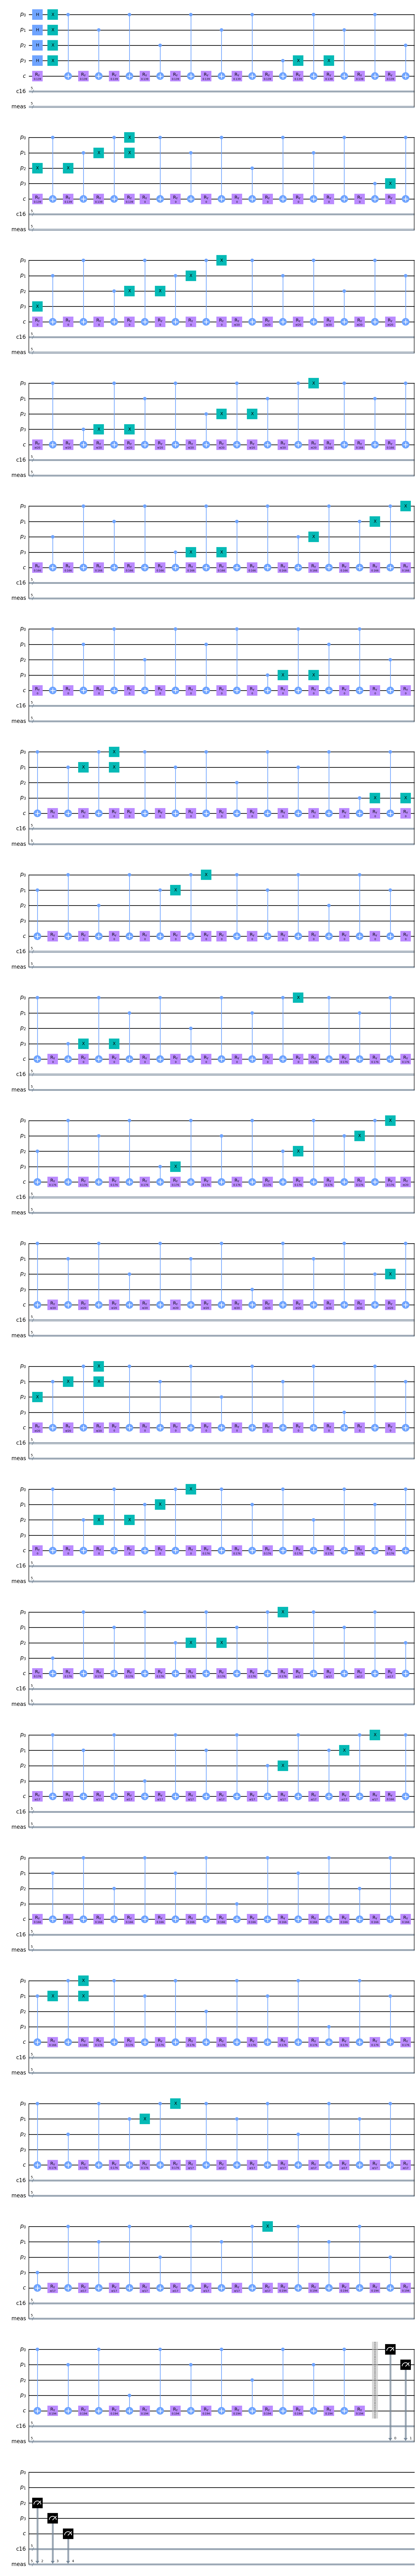

In [ ]:
#Run FRQI for both images
print("Running FRQI on the image with ellipse...")
qc_with_ellipse, result_with_ellipse = run_frqi_v2(image_with_ellipse)
qc_with_ellipse.draw("mpl", style="clifford")

Running FRQI on the image without ellipse...


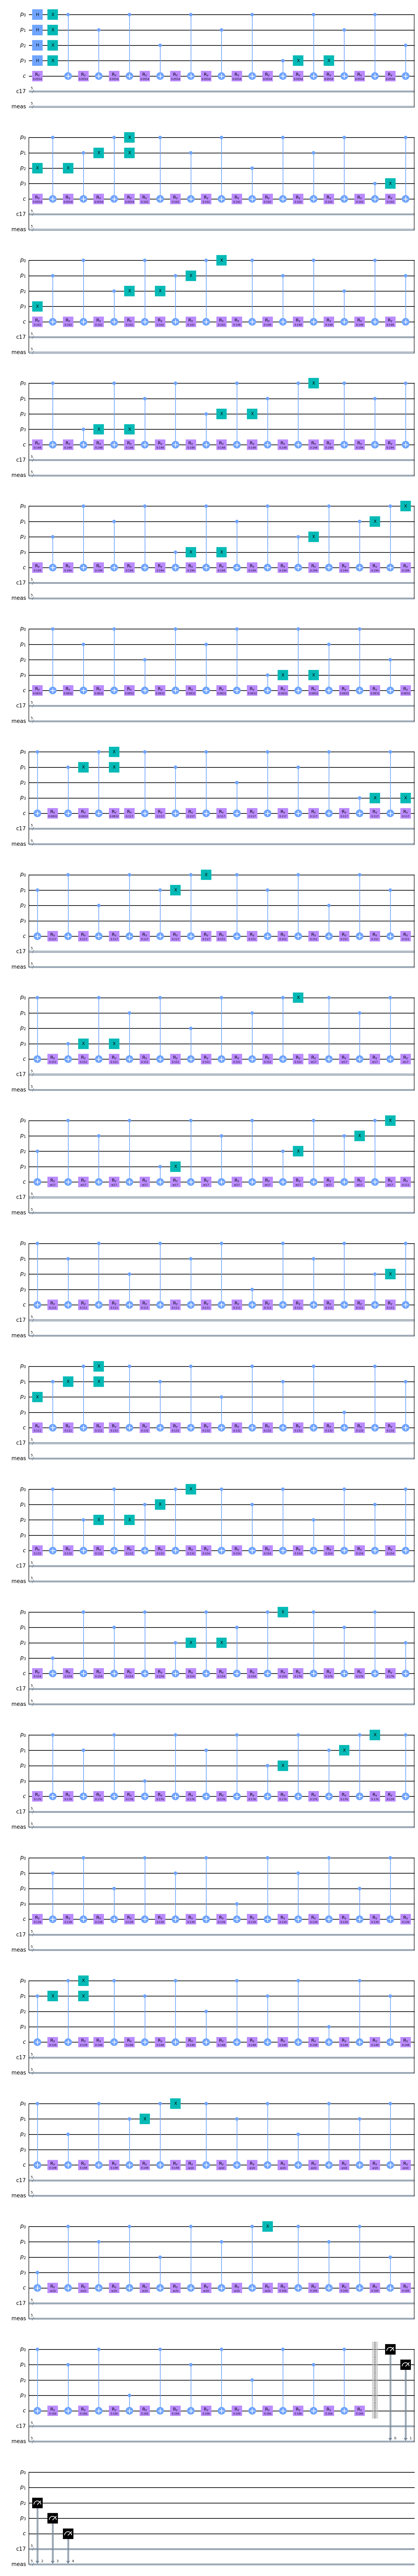

In [ ]:
print("Running FRQI on the image without ellipse...")
qc_without_ellipse, result_without_ellipse = run_frqi_v2(image_without_ellipse)
qc_without_ellipse.draw("mpl", style="clifford")

In [ ]:
#Function to reconstruct image from FRQI results
def reconstruct_image(result, img_size, shots):
  reconstruction = np.zeros((img_size, img_size))
  num_bits = int(np.log2(img_size))

  for i, j in it.product(range(img_size), repeat=2):
    ibin = format(i, f'0{num_bits}b')
    jbin = format(j, f'0{num_bits}b')
    qubit_string_0 = '0' + ibin + jbin  #'0' is for the color qubit
    qubit_string_1 = '1' + ibin + jbin  #'1' is for the color qubit

    N0 = result.data.meas.get_counts().get(qubit_string_0, 0)
    N1 = result.data.meas.get_counts().get(qubit_string_1, 0)
    reconstruction[i, j] = N1 / (N0 + N1)

  return reconstruction

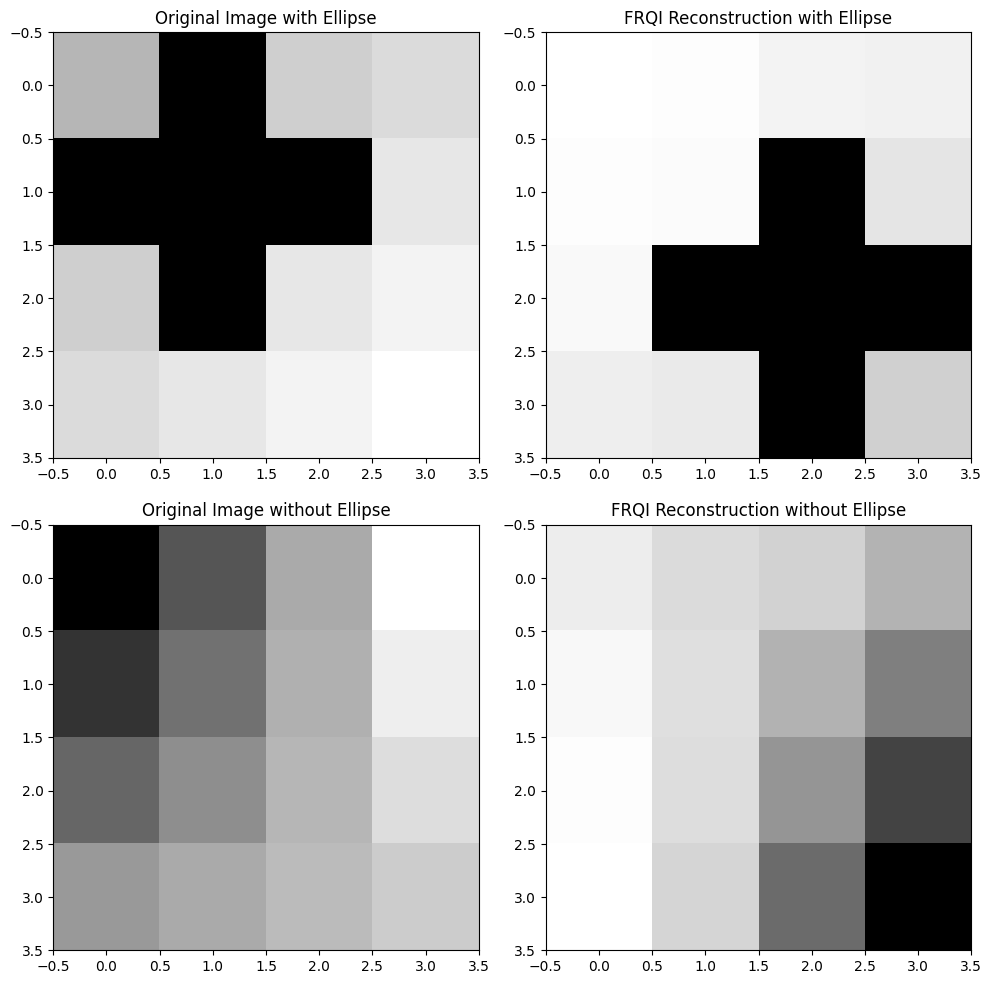

In [ ]:
#Reconstruct the images
img_size = image_with_ellipse.shape[0]
reconstruction_with_ellipse = reconstruct_image(result_with_ellipse, img_size, 10000)
reconstruction_without_ellipse = reconstruct_image(result_without_ellipse, img_size, 10000)

#Visualize the results
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0, 0].imshow(image_with_ellipse, cmap='gray')
axs[0, 0].set_title('Original Image with Ellipse')

axs[0, 1].imshow(reconstruction_with_ellipse, cmap='gray')
axs[0, 1].set_title('FRQI Reconstruction with Ellipse')

axs[1, 0].imshow(image_without_ellipse, cmap='gray')
axs[1, 0].set_title('Original Image without Ellipse')

axs[1, 1].imshow(reconstruction_without_ellipse, cmap='gray')
axs[1, 1].set_title('FRQI Reconstruction without Ellipse')

plt.tight_layout()
plt.show()